In [3]:
import os
import os.path as op
import mne
import numpy as np
import re
import itertools
# import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
# from typing import Tuple, Iterator
# from mne_bids import BIDSPath, read_raw_bids, print_dir_tree
# from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
# from bids import BIDSLayout
from util.io.iter_BIDSPaths import *

ModuleNotFoundError: No module named 'mne_bids'

In [6]:
BIDS_ROOT = '../data/bids'
STIM_FREQS = np.array([50, 100, 150, 200, 250])
FS = 2000

In [3]:
os.getcwd()

'/project2/hcn1/pitch_tracking/scripts'

## Functions

In [7]:
KeyType = Tuple[str, str, str, str]

def get_fpaths(bids_root) -> Iterator[KeyType]:
    # Get filepaths
    layout = BIDSLayout(bids_root, derivatives = True)
    fpaths = layout.get(scope = 'preprocessing',
                        extension = 'fif.gz',
                        return_type = 'filename')
    fpaths.pop(0)
    
    # Get corresponding subject number
    filter_subs = re.compile('sub-(\d)_')
    subs = list(map(filter_subs.findall, fpaths))
    subs = list(itertools.chain(*subs))
    
    # Get corresponding run number
    filter_runs = re.compile('run-(\d)')
    runs = list(map(filter_runs.findall, fpaths))
    runs = list(itertools.chain(*runs))
    
    for i in range(len(fpaths)):
        key = (fpaths[i], subs[i], 'tasks', runs[i])
        yield key

def load_fif(fname):
    epochs = mne.read_epochs(fname)
    return epochs

def get_power_at_stim_freqs(epochs, stim_freqs):
    n_cycles = stim_freqs / 7.  # different number of cycle per frequency
    power = tfr_morlet(epochs, 
                       freqs = stim_freqs, 
                       n_cycles = n_cycles, 
                       use_fft = True,
                       return_itc = False, 
                       decim = 3, 
                       n_jobs = 1,
                       average = False)

    return power

## Analysis

### Compute power 
Compute power at each possible stim frequency for each epoch. 

Doing this only for one subject right now, hence the broken for loop.

In [8]:
# powers = []
# events = []
for (fpath, sub, task, run) in get_fpaths(BIDS_ROOT):
    epochs = load_fif(fpath)
    epochs = epochs.crop(tmin = 0)
#     events.append(mne.read_events(fpath)) #CHANGEBACK
    events = mne.read_events(fpath)
    power = get_power_at_stim_freqs(epochs, STIM_FREQS)
    log_power = np.log10(power)
#     powers.append(log_power) #CHANGEBACK
#     power = log_power 
    break

BIDSValidationError: 'dataset_description.json' is missing from project root. Every valid BIDS dataset must have this file.
Example contents of 'dataset_description.json': 
{"Name": "Example dataset", "BIDSVersion": "1.0.2"}

### Create dataframe
#### Reshape power and create dataframe

In [44]:
# Get some information
power = log_power 
n_epochs = np.shape(power)[0]
n_channels = np.shape(power)[1]
n_freqs = np.shape(power)[2]
n_windows = np.shape(power)[3]

# Print information
print("Number of epochs: " + str(n_epochs))
print("Number of channels: " + str(n_channels))
print("Number of freqs: " + str(n_freqs))
print("Number of windows: " + str(n_windows))


Number of epochs: 4553
Number of channels: 62
Number of freqs: 5
Number of windows: 167


In [45]:
# Average power over all channels
power = np.mean(power, axis = 1)

# Reshape power to tidy format
power_tidy = power.reshape((n_epochs * n_freqs, n_windows), order = 'F') # Set order to preserve epoch order

# Compare the two shapes, make sure values are broadcasted in the right way
print(power[1:20, 1, 0] == power_tidy[n_epochs+1:n_epochs+20, 0])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]


#### Add row information

In [14]:
# Recode events
events_codes = events[:, 2]
df = pd.Series(events_codes)
event_codes = df.replace({10001 : 50, 10002 : 100, 10003 : 150, 10004 : 200, 10005 : 250})

In [34]:
# Create condition column
condition = pd.concat([event_codes]*n_freqs)
condition = condition.reset_index(drop = True)

# Create frequency column
freq = pd.Series(STIM_FREQS)
freq = freq.repeat(n_epochs)
freq = freq.reset_index(drop = True)

# Create data frame with row info
row_info = pd.DataFrame({'condition': condition, 'freq': freq})

In [16]:
# Add to data frame
df = pd.concat([row_info, pd.DataFrame(power_tidy)], axis=1)
df

condition  freq          0          1          2          3          4  \
0            250    50 -10.584059 -10.561691 -10.543403 -10.529400 -10.519729   
1            250    50 -10.443523 -10.413736 -10.385619 -10.359377 -10.335107   
2             50    50 -10.502987 -10.449036 -10.396934 -10.346742 -10.298524   
3             50    50 -10.630683 -10.597827 -10.569789 -10.547069 -10.530393   
4             50    50 -10.719271 -10.684176 -10.653178 -10.628512 -10.578093   
...          ...   ...        ...        ...        ...        ...        ...   
22760         50   250 -11.570948 -11.538809 -11.510812 -11.486794 -11.466780   
22761        150   250 -11.491503 -11.463771 -11.439565 -11.418743 -11.400480   
22762        100   250 -11.601201 -11.581399 -11.546494 -11.502555 -11.468032   
22763         50   250 -11.429953 -11.395586 -11.364796 -11.337862 -11.314892   
22764         50   250 -11.654964 -11.614919 -11.575928 -11.537786 -11.500499   

               5          6          7  ...        157        158        159  \
0     -10.514367 -10.513072 -10.514771  ... -10.420302 -10.455760 -10.480862   
1     -10.312696 -10.291942 -10.272836  ... -10.185412 -10.192355 -10.202576   
2     -10.252359 -10.208305 -10.166385  ... -10.351314 -10.363191 -10.378928   
3     -10.521202 -10.516540 -10.498913  ... -10.591713 -10.593862 -10.612819   
4     -10.535982 -10.502756 -10.469857  ... -10.495315 -10.507439 -10.522225   
...          ...        ...        ...  ...        ...        ...        ...   
22760 -11.451006 -11.440073 -11.435686  ... -11.415963 -11.418249 -11.422970   
22761 -11.381491 -11.359408 -11.337311  ... -11.456594 -11.484739 -11.513734   
22762 -11.438431 -11.412572 -11.389638  ... -11.421065 -11.431001 -11.442803   
22763 -11.293320 -11.267603 -11.242439  ... -11.359204 -11.382769 -11.409242   
22764 -11.464955 -11.432480 -11.404147  ... -11.300299 -11.306825 -11.317325   

             160        161        162        163        164        165  \
0     -10.493197 -10.514844 -10.541328 -10.571582 -10.605275 -10.642319   
1     -10.216050 -10.232751 -10.252644 -10.275677 -10.301769 -10.330789   
2     -10.398868 -10.423124 -10.451477 -10.482486 -10.513441 -10.545151   
3     -10.638992 -10.658520 -10.671679 -10.690360 -10.713945 -10.742184   
4     -10.539552 -10.558928 -10.579427 -10.600176 -10.621193 -10.643277   
...          ...        ...        ...        ...        ...        ...   
22760 -11.426197 -11.424801 -11.428523 -11.438363 -11.453539 -11.473452   
22761 -11.545113 -11.591057 -11.595735 -11.603477 -11.601639 -11.603729   
22762 -11.457212 -11.474468 -11.494582 -11.517486 -11.543097 -11.571325   
22763 -11.438600 -11.473135 -11.516589 -11.528776 -11.553864 -11.581877   
22764 -11.331596 -11.349305 -11.369977 -11.392953 -11.417497 -11.443251   

             166  
0     -10.682725  
1     -10.362556  
2     -10.580156  
3     -10.775245  
4     -10.667234  
...          ...  
22760 -11.497732  
22761 -11.612114  
22762 -11.602036  
22763 -11.607330  
22764 -11.470532  

[22765 rows x 169 columns]

In [58]:
# Create dataframe for classifier (trials x features x time), one for each subject
power = log_power
power_mne = power.reshape((n_epochs, n_freqs * n_channels, n_windows)) # Set order to preserve epoch order

sample_1 = power[1:20, 0, 0]

# Sanity check
sample_2 = power.reshape((n_epochs, n_channels, n_freqs, n_windows))[1:20, 0, 0]
# print(np.shape(power_mne))
# print(power[1:20, 0, 1, 0])
# print(power_mne[1:20, n_channels+1, 0])
# print(power[1:20, 0, 1, 0] == power_mne[1:20, n_channels+1, 0]) # would expect these to be the same

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

#### Calculate group means

In [ ]:
means = df.groupby(['condition', 'freq'], as_index=False).mean()
means
means.to_csv('mean_freqs.csv')

### Plots

<AxesSubplot:xlabel='window', ylabel='value'>

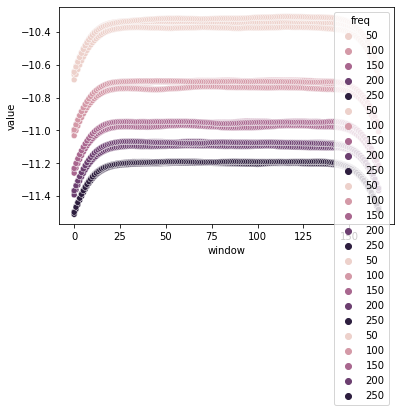

In [11]:
# # Pivot by window number
# means_longer = pd.melt(means, id_vars=['condition', 'freq'], var_name = 'window')

# # Subset by condition
# means_50 = means_longer[means_longer['condition'] == 50]
# means_100 = means_longer[means_longer['condition'] == 100]
# means_150 = means_longer[means_longer['condition'] == 150]
# means_200 = means_longer[means_longer['condition'] == 200]
# means_250 = means_longer[means_longer['condition'] == 250]

# # Plot
# sns.scatterplot(x='window', y='value', hue='freq', data=means_50) 
# sns.scatterplot(x='window', y='value', hue='freq', data=means_100) 
# sns.scatterplot(x='window', y='value', hue='freq', data=means_150) 
# sns.scatterplot(x='window', y='value', hue='freq', data=means_200) 
# sns.scatterplot(x='window', y='value', hue='freq', data=means_250) 

In [ ]:
# for each subject

# mean power at frequency that matches condition

# mean power at frequency that doesn't match condition

In [12]:
means_150

condition  freq window      value
10          150    50      0 -10.659503
11          150   100      0 -11.007067
12          150   150      0 -11.240793
13          150   200      0 -11.370743
14          150   250      0 -11.501345
...         ...   ...    ...        ...
4160        150    50    166 -10.632918
4161        150   100    166 -10.979348
4162        150   150    166 -11.208427
4163        150   200    166 -11.350860
4164        150   250    166 -11.484090

[835 rows x 4 columns]